<a href="https://colab.research.google.com/github/HauwaUmar/DATA-6100/blob/main/Updated%206100%20Assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary

# Ethic Discussion

# Detailed Report

## I. Importing libraries

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import itertools

## II. Loading dataset

In [2]:
#reading the held out train and test sets 
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

train_dataset.shape, test_dataset.shape

((8693, 14), (4277, 13))

We have 13 explanatory variables. The target is present in the train dataset but not the test dataset.

In [3]:
# combine both testing and training dataset for data cleaning and transformation
whole_dataset = pd.concat((train_dataset, test_dataset)).reset_index(drop = True)

# storing the PassengerId for the test dataset
test_id = test_dataset['PassengerId']
whole_dataset.shape

(12970, 14)

## Exploratory Analysis

We are trying to predict who got transported and who didn't. We will do some analysis on this first.

Using a histogram, we check how the data in Transported is shared.

In [24]:
#plotting a histogram for transported column
px.histogram(train_dataset,x="Transported",color="Transported",width=600,height=400)

There seems to be a balance between those that got transported and those that did not. We will explore the rest of the dataset.

In [4]:
# information about the dataset
whole_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


There's a combination of numeric and non-numeric columns in the dataset and most columns have missing values which will be handled later.

In [5]:
#statistical description of the data for categorical variables
whole_dataset.select_dtypes(include='object').describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,12970,12682,12660,12671,12696,12674,12676,8693
unique,12970,3,2,9825,3,2,12629,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Carry Contrevins,True
freq,1,6865,8079,8,8871,12401,2,4378


The  table above shows that there are 3 unique Home Planets and Destinations with most coming from Earth.CryoSleep and VIP are boolean values.Transported is our target variable which also contains boolean values.

In [6]:
#statistical description of the data for numerical variables
whole_dataset.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The table above depicts that on the average age of people on the space ship is 28 with the youngest being 0(probably a new born baby) and the oldest being 79. On average more money was spent at the food court compared to the other options [Room Service, Shopping Mall, Spa, VRDeck].

### CryoSleep

In [50]:
#displaying a countplot for CryoSleep, classified by whether a passenger was transported or not
cryo_data = train_dataset[~train_dataset['CryoSleep'].isnull()]
px.histogram(cryo_data,x="CryoSleep",color="Transported",barmode="group",width=600,height=400)

Based on CryoSleep alone, most people who were not confined to their cabins were not transported. So this is might be an important observation.

### Home Planet

In [26]:
# returning only rows were Home Planet is not null
planet_data = train_dataset[~train_dataset['HomePlanet'].isnull()]

#plotting count histogram for each Home planet and grouped by Transported column
px.histogram(planet_data,x="HomePlanet",color="Transported",barmode="group",width=600,height=400)

Majority of the population is from earth. Since we wouldn't anticipate that your place of origin would affect whether you were moved (but who knows what we're dealing with), the distribution between the three planets is noteworthy. Therefore, we wonder if there is any context that is still needed.

### VIP

In [25]:
# returning only rows were VIP is not null
vip_data = train_dataset[~train_dataset['VIP'].isnull()]
px.histogram(vip_data,x="VIP",color="Transported",barmode="group",width=600, height=400)

It is obvious that a lot of people would not  be VIP's. However, it seems that the VIP status of a passenger did not play a huge role in whether or not a passenger got transported.

In [27]:
# returning only rows were Destination is not null
destination_data = train_dataset[~train_dataset['Destination'].isnull()]
px.histogram(destination_data,x="Destination",color="Transported",barmode="group",width=600, height=400)

A lot of passengers planned to arrive at TRAPPIST-1e and almost 50% did not arrive. A higher percentage of passengers that planned to arrive at 55 Cancri e did arrive. And as for PSO J318.5-22, it is significantly equal; the percentage of passengers arrived and those who didn't. 

### Cabin


In the data description it is stated that each passenger is either on the port side or starboard side. 

An example of the data in this column is 
- A/0/S
- B/0/P
 
There's a pattern present, each data point has 3 sections. The goal is to get the side the passenger was on. 

In [29]:
# spliting getting only the side the passengers cabin were located
train_dataset['Cabin']= train_dataset['Cabin'].apply(lambda x: str(x).split('/')[-1])

In [30]:
#Showing values in Cabin column
train_dataset['Cabin'].unique()

array(['P', 'S', 'nan'], dtype=object)

There is "nan" because there are none values but again that will be handled later.

In [28]:
# returning only rows were Cabin is not null
cabin_data = train_dataset[train_dataset['Cabin'] != 'nan']
px.histogram(cabin_data,x="Cabin",color="Transported",barmode="group",width=600, height=400)

It seems there is a higher chance you'd get transported than not transported if you are in the star board side compared to Port side which is the opposite

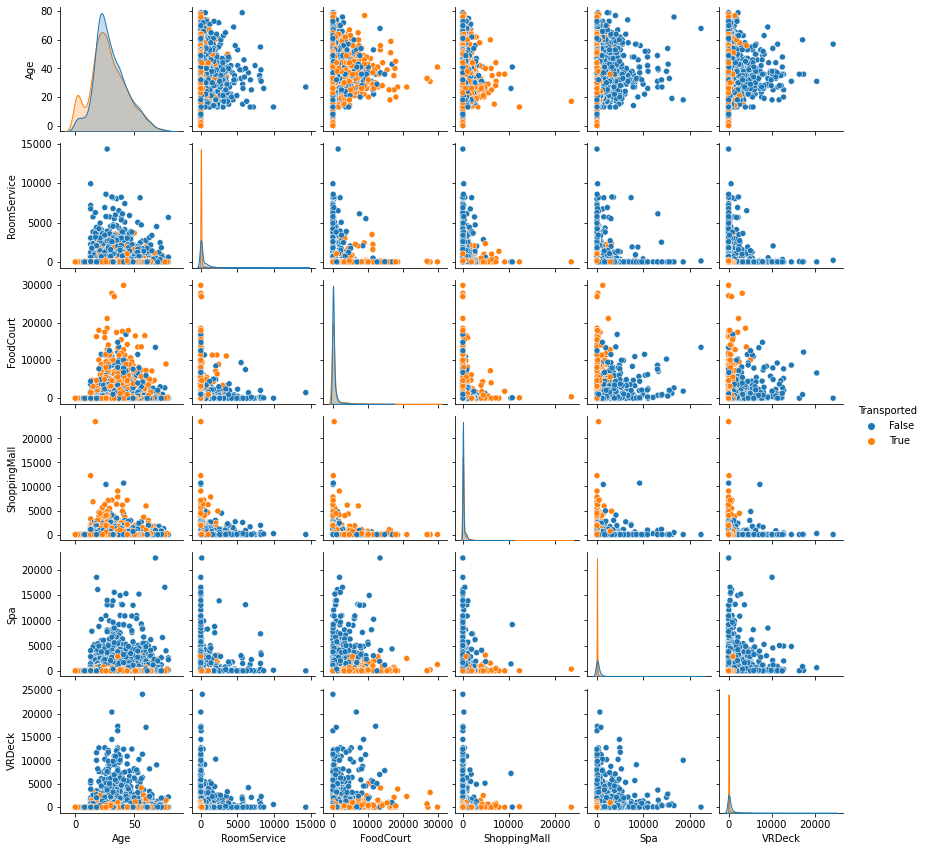

In [45]:
numeric_cols = train_dataset._get_numeric_data().columns
sns.pairplot(train_dataset,
    vars=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
    hue="Transported",dropna=True,height=2)

From the pair plot, it seems the age of the passengers did not play a huge role in the 

## IV. Handling Missing Data

Remember we concatenated the train and test data set to a dataframe called "whole_dataset". We will use that for our data cleaning so both datasets can be the same when modelling.

In [59]:
# this function will go through the data frame and return information on columns with missing values such as the number of missing data in
# each column and the percentage of missing value overall for each column
def info_on_missing_values(df):
  """
      Params: df: dataframe to find missing values from
      
      Returns: dataframe containing information on missing values of input df

  """
  total_missing_values = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
  percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
  data_type = df.dtypes.sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
  decription_of_missing_values = pd.concat([total_missing_values, percentage, data_type], axis=1, keys=['Total Missing Val','Percentage','Data Type'])
  return decription_of_missing_values

info_on_missing_values(whole_dataset.drop('Transported',axis=1))

,Total Missing Val,Percentage,Data Type
CryoSleep,310,2.39,object
ShoppingMall,306,2.36,float64
Cabin,299,2.31,object
VIP,296,2.28,object
Name,294,2.27,object
FoodCourt,289,2.23,float64
HomePlanet,288,2.22,object
Spa,284,2.19,float64
Destination,274,2.11,object
Age,270,2.08,float64


For each column not a lot of data is missing but if we decide to drop all the columns with na that would make us lose a lot of vital data 

It is intuitive to think The Passenger ID is not useful for the prediction but some patterns were noticed in the column.

Example of data in Passenger_id column:

- 0031_01
- 0031_02
- 0031_03

The id's above are for different passengers. Multiple passengers can belong to a group but have different group numbers. We are going to split this information and see if it helps